# HEP-like INFERNO

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

## 1. Interpolation algorithm

In [2]:
from pytorch_inferno.inference import *

In [97]:
def smooth_function(x, smoothRegion = 1):
    
    mask_smooth_region = torch.abs(x) > smoothRegion
    xnorm = x / smoothRegion
    xnorm2 = xnorm*xnorm
    
    in_smooth = 0.125 * xnorm * (xnorm2 * (3.*xnorm2 - 10.) + 15)
    out_smooth = torch.where(x>0, torch.ones(x.shape).to(x.device), -1*torch.ones(x.shape).to(x.device))
    
    return torch.where(mask_smooth_region, out_smooth, in_smooth)

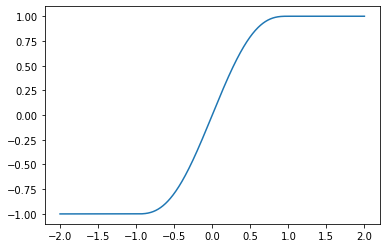

In [68]:
# Test 
x = torch.linspace(-2, 2, 1000)
y = smooth_function(x)
plt.plot(x, y)

In [98]:
def morph(x, nominal, lo, hi):
        
    dhi = hi - nominal
    dlo = lo - nominal
    #print(dhi)
    #print(dlo)
    diff_h = dhi - dlo
    sum_h = dhi + dlo
    alpha = x * 0.5 * ((diff_h) + (sum_h)*smooth_function(x))
    return alpha

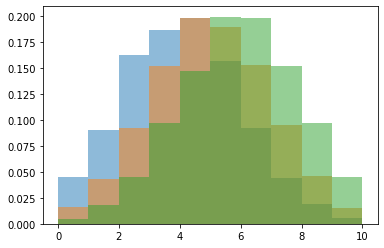

In [6]:
# Test
hi, y,_ = plt.hist(np.random.normal(loc=4, scale=2.0, size=10000), range=(0,10), alpha=0.5, density=True)
nominal, y,_ = plt.hist(np.random.normal(loc=5, scale=2.0, size=10000), range=(0,10), alpha=0.5, density=True)
lo, y,_ = plt.hist(np.random.normal(loc=6, scale=2.0, size=10000), range=(0,10), alpha=0.5, density=True)

In [7]:
hi_t = torch.Tensor(hi)
nominal_t = torch.Tensor(nominal)
lo_t = torch.Tensor(lo)

In [8]:
hi_stacked = torch.stack([hi_t, hi_t, hi_t])
lo_stacked = torch.stack([lo_t, lo_t, lo_t])

In [9]:
nominal_stacked = nominal_t.unsqueeze(0).repeat(3, 1)

In [10]:
nominal_stacked.shape

torch.Size([3, 10])

In [11]:
alpha = torch.Tensor(np.array([-1, 0., 1.])).unsqueeze(1)

In [12]:
nominal_stacked = nominal_t.unsqueeze(0).repeat(x.shape[0], 1)

In [13]:
nominal_stacked = nominal_t.unsqueeze(0).repeat(alpha.shape[0], 1)
morphed = morph(alpha, nominal_stacked, lo_stacked, hi_stacked)

In [14]:
nominal_t += morphed.sum(0)

In [15]:
nominal_t

tensor([0.0331, 0.0648, 0.1144, 0.1318, 0.1471, 0.1667, 0.1375, 0.1000, 0.0695,
        0.0350])

In [99]:
def fast_vertical(alpha:Tensor, f_nom:Tensor, f_up:Tensor, f_dw:Tensor):
    
    f_nom_rep = f_nom.unsqueeze(0).repeat(alpha.shape[0], 1)
    return f_nom + morph(alpha.unsqueeze(1), f_nom_rep, f_dw, f_up).sum(0)

## 2. constraints

In [161]:
def normal(theta, std):
    return 1. + theta*std

In [17]:
def log_normal(theta, kappa):
    return torch.exp(theta * torch.log(kappa))

In [18]:
def logKappaForX(x, logkappa_lo, logkappa_hi):
    
    logKhi =  logkappa_hi
    logKlo = -logkappa_lo

    kappa = torch.where(x >= 0, logkappa_hi, -logkappa_lo)
    
    avg = 0.5*(logKhi + logKlo) 
    halfdiff = 0.5*(logKhi - logKlo)
    twox = x+x 
    twox2 = twox*twox
    alpha = 0.125 * twox * (twox2 * (3*twox2 - 10.) + 15.)
    ret = avg + alpha*halfdiff
    return torch.where(torch.abs(x) >= 0.5, kappa, ret)

In [19]:
theta = torch.Tensor([1.0])
kappa = torch.Tensor([1.1])
std = torch.Tensor([0.1])
kappa_lo = torch.Tensor([0.9])
kappa_hi = torch.Tensor([1.2])
kappa_std_avg = (abs(kappa_hi-1)+abs(1-kappa_lo))/2

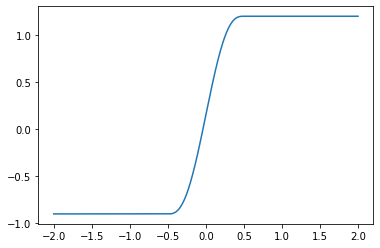

In [20]:
# Test 
x = torch.linspace(-2, 2, 1000)
y_logKappaForX = logKappaForX(x, kappa_lo, kappa_hi)
plt.plot(x, y_logKappaForX)

In [21]:
def asym_log_normal(theta, kappaLo, kappaHi):
    return torch.exp(theta * logKappaForX(theta, torch.log(kappaLo), torch.log(kappaHi)))

In [22]:
kappa_std_avg

tensor([0.1500])

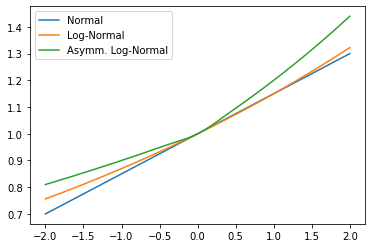

In [23]:
# Test 
x = torch.linspace(-2, 2, 1000)
y_norm = normal(x, kappa_std_avg)
y_ln = log_normal(x, (1+kappa_std_avg))
y_lnasym = asym_log_normal(x, kappa_lo, kappa_hi)
plt.plot(x, y_norm, label="Normal")
plt.plot(x, y_ln, label="Log-Normal")
plt.plot(x, y_lnasym, label="Asymm. Log-Normal")
plt.legend()

## 3. NLL

In [24]:
from typing import *
from torch import Tensor
from torch.distributions import Distribution
from torch.distributions import Normal

In [162]:
def hep_nll(s_true:float, b_true:float, mu:Tensor, f_s_nom:Tensor, f_b_nom:Tensor,
             shape_alpha:Optional[Tensor]=None, s_norm_alpha:Optional[Tensor]=None, 
             b_norm_alpha:Optional[Tensor]=None, b_rate_param_alpha:Optional[Tensor]=None,
             f_s_up:Optional[Tensor]=None, f_s_dw:Optional[Tensor]=None,
             f_b_up:Optional[Tensor]=None, f_b_dw:Optional[Tensor]=None,
             shape_norm_sigma:Optional[Tensor]=None, s_norm_sigma:Optional[Tensor]=None, 
             b_norm_sigma:Optional[Tensor]=None, 
             interp_algo:str="fast_vertical") -> Tensor:
    r'''Compute negative log-likelihood for specified parameters.'''
    
    #  Interpolate shapes
    if interp_algo == "fast_vertical":
        f_s = fast_vertical(shape_alpha, f_s_nom, f_s_up, f_s_dw) if shape_alpha is not None and f_s_up is not None else f_s_nom
        f_b = fast_vertical(shape_alpha, f_b_nom, f_b_up, f_b_dw) if shape_alpha is not None and f_b_up is not None else f_b_nom        
    else:
        #print(shape_alpha)
        #print(f_s_nom, f_s_up, f_s_dw)
        f_s = interp_shape(shape_alpha, f_s_nom, f_s_up, f_s_dw) if shape_alpha is not None and f_s_up is not None else f_s_nom
        f_b = interp_shape(shape_alpha, f_b_nom, f_b_up, f_b_dw) if shape_alpha is not None and f_b_up is not None else f_b_nom
    
    # Normalizations !!! careful if signal and background shapes mix!!
    #print("shape_norm_sigma", shape_norm_sigma)
    s_exp, b_exp = mu, b_true
    if len(shape_alpha) > 0:
        #print("Norms shape", normal(shape_alpha, shape_norm_sigma))
        mu *= normal(shape_alpha, shape_norm_sigma).prod()  
    if len(s_norm_alpha) > 0:
        mu *= normal(s_norm_alpha, s_norm_sigma).prod()
    if len(b_norm_alpha) > 0:
        b_exp *= normal(b_norm_alpha, b_norm_sigma).prod()
    if (b_rate_param_alpha  is not None) and (len(b_rate_param_alpha) > 0):
        b_exp *= b_rate_param_alpha
    #  Compute NLL
    t_exp = (s_exp*f_s)+(b_exp*f_b)
    asimov = (s_true*f_s_nom)+(b_true*f_b_nom)
    nll = -torch.distributions.Poisson(t_exp, False).log_prob(asimov).sum()
    # Constrain shape +norm nuisances
    for a in shape_alpha: nll = nll - Normal(0,1).log_prob(a)
    for a in b_norm_alpha: nll = nll - Normal(0,1).log_prob(a)
    for a in s_norm_alpha: nll = nll - Normal(0,1).log_prob(a)
    return nll

## 4. Callback

## 5. Setup INFERNO

In [163]:
from pytorch_inferno.inferno import *
from fastcore.all import store_attr, delegates, is_close

In [212]:
class HEPInferno(AbsInferno):
    r'''Implementation of INFERNO with HEP like systematics'''
    @delegates(AbsInferno)
    def __init__(self, interp_algo:str="default", shape_norm_sigma:Optional[List[float]]=None,
                 s_norm_sigma:Optional[List[float]]=None, b_norm_sigma:Optional[List[float]]=None, 
                 b_rate_param:bool=False, **kwargs):
        super().__init__(**kwargs)
        self.interp_algo = interp_algo
        self.shape_norm_sigma = shape_norm_sigma #torch.Tensor(shape_norm_sigma)
        self.s_norm_sigma = s_norm_sigma
        self.b_norm_sigma = b_norm_sigma
        self.b_rate_param = b_rate_param
        # Compute nuisance indeces
        self.poi_idx = [0]
        # Shape + norm
        if self.shape_norm_sigma is not None and len(self.shape_norm_sigma) != self.n_shape_alphas: raise ValueError("Number of norm uncertainties on shape nuisances must match the number of shape nuisance parameters")
        if self.n_shape_alphas > 0:
            self.shape_idxs = list(range(1,self.n_shape_alphas+1))
            self.n_alpha = 1+self.n_shape_alphas
        else:
            self.shape_idxs = []
        # Signal norms
        if self.s_norm_sigma is not None and len(self.s_norm_sigma) > 0:
            self.s_norm_idxs = list(range(self.n_alpha, self.n_alpha+len(self.s_norm_sigma)))
            self.n_alpha += len(self.s_norm_sigma)
        else:
            self.s_norm_idxs = []
        # Background norms + possible rate param
        if self.b_norm_sigma is not None and len(self.b_norm_sigma) > 0:
            self.b_norm_idxs = list(range(self.n_alpha, self.n_alpha+len(self.b_norm_sigma)))
            self.n_alpha += len(self.b_norm_sigma)
        else:
            b_norm_idxs = []
        if self.b_rate_param:
            self.b_rate_param_idx = list(self.n_alpha, self.n_alpha+1)
            self.n_alpha += 1
        else:
            self.b_rate_param_idx = []
        
        # Store covariance matrix
        self.covs = 0
        self.cnt = 0
        
        print("*********************")
        print("Summary INFERNO setup")
        print("b_true", self.b_true)
        print("mu_true", self.mu_true)
        print("nshape_alphas", self.n_shape_alphas)
        print("shape idx", self.shape_idxs)
        print("shape_norm_sigma", self.shape_norm_sigma)
        print("s_norm_sigma", self.s_norm_sigma)
        print("s_norm_idxs", self.s_norm_idxs)
        print("b_norm_sigma", self.b_norm_sigma)
        print("b_norm_idxs", self.b_norm_idxs)
        print("b_rate_param", self.b_rate_param)
        print("n_alpha", self.n_alpha)
        print("interp_algo", self.interp_algo)
        print("*********************")

    def _aug_data(self): pass  # Override abs method
    def on_batch_begin(self) -> None: pass
    def on_batch_end(self) -> None: pass
    def on_epoch_begin(self) -> None: self.covs=0
    def on_epoch_end(self) -> None:
        if self.wrapper.state == 'train':
            print("Covmat train", self.covs/self.cnt)
        else:
            print("Covmat val", self.covs/self.cnt)

    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct        
        if self.shape_norm_sigma is not None: self.shape_norm_sigma = torch.Tensor(self.shape_norm_sigma).to(self.wrapper.device)
        if self.s_norm_sigma is not None: self.s_norm_sigma = torch.Tensor(self.s_norm_sigma).to(self.wrapper.device)
        if self.b_norm_sigma is not None: self.b_norm_sigma = torch.Tensor(self.b_norm_sigma).to(self.wrapper.device)

    def _get_up_down(self, x_s:Tensor, x_b:Tensor, w_s:Optional[Tensor]=None, w_b:Optional[Tensor]=None) -> Tuple[Tuple[Optional[Tensor],Optional[Tensor]],Tuple[Optional[Tensor],Optional[Tensor]]]:

        if self.n_shape_alphas != ((x_s.shape[-1]-1)/2): 
            raise ValueError("Number of specified shape nuisances n_shape_alphas", self.n_shape_alphas,
                             "must match the number of systematic variations:", (x_s.shape[-1]-1)/2 )
        
        u,d = [],[]
        # modified template variations
        for i in range(self.n_shape_alphas):
            idx_up = 1 + 2*i
            idx_down = 2 + 2*i
            up_batch = self.to_shape(self.wrapper.model(x_s[:,:,idx_up]))
            down_batch = self.to_shape(self.wrapper.model(x_s[:,:,idx_down]))
            u.append(up_batch)
            d.append(down_batch)    
        return (torch.stack(u),torch.stack(d)), (None,None)

    def get_ikk(self, f_s_nom:Tensor, f_b_nom:Tensor, f_s_up:Optional[Tensor], f_s_dw:Optional[Tensor], f_b_up:Optional[Tensor], f_b_dw:Optional[Tensor]) -> Tensor:
        r'''Compute full hessian at true param values, or at random starting values with Newton updates'''
        alpha = torch.zeros((self.n_alpha), requires_grad=True, device=self.wrapper.device)
        with torch.no_grad(): alpha[self.poi_idx] += self.mu_true
        #print("alpha", alpha)
        get_nll = partialler(hep_nll, s_true=self.mu_true, b_true=self.b_true, # Expectation values
                             f_s_nom=f_s_nom, f_b_nom=f_b_nom, # Nominal shapes
                             f_s_up=f_s_up, f_s_dw=f_s_dw, # Signal shapes
                             f_b_up=f_b_up, f_b_dw=f_b_dw, #Background shapes
                             shape_norm_sigma = self.shape_norm_sigma, # Norm unct on shapes
                             s_norm_sigma = self.s_norm_sigma, b_norm_sigma = self.b_norm_sigma # Norm unct on sig and bkg
                             ) 
        nll = get_nll(mu=alpha[self.poi_idx], s_norm_alpha=alpha[self.s_norm_idxs], 
                      b_norm_alpha=alpha[self.b_norm_idxs], shape_alpha=alpha[self.shape_idxs],
                      b_rate_param_alpha = alpha[self.b_rate_param_idx],
                      interp_algo = self.interp_algo)
        _,h = calc_grad_hesse(nll, alpha, create_graph=True)
        cov = torch.inverse(h)        
        with torch.no_grad(): self.covs += cov.detach().cpu().numpy()
        self.cnt += 1
        return cov[self.poi_idx,self.poi_idx]

    def on_forwards_end(self) -> None:
        r'''Compute loss and replace wrapper loss value'''
        b = self.wrapper.y.squeeze() == 0
        w_s = self.wrapper.w[~b] if self.wrapper.w is not None else None
        w_b = self.wrapper.w[b] if self.wrapper.w is not None else None
        f_s = self.to_shape(self.wrapper.y_pred[~b], w_s)
        f_b = self.to_shape(self.wrapper.y_pred[b], w_b)
        (f_s_up,f_s_dw),(f_b_up,f_b_dw)= self._get_up_down(self.wrapper.x[~b], self.wrapper.x[b], w_s, w_b)
        self.wrapper.loss_val = self.get_ikk(f_s_nom=f_s, f_b_nom=f_b, f_s_up=f_s_up, f_s_dw=f_s_dw, f_b_up=f_b_up, f_b_dw=f_b_dw)


In [214]:
# Set up network
net_inferno = nn.Sequential(nn.Linear(4,100),  nn.ReLU(),
                nn.Linear(100,100), nn.ReLU(),
                nn.Linear(100,10), VariableSoftmax(0.1))
lt = LossTracker()
hep_inf = HEPInferno(b_true=qcd, mu_true=mu, n_shape_alphas=2, shape_norm_sigma=shape_norm_sigma,
                                 s_norm_sigma=s_norm_sigma, interp_algo="fast_vertical")
#init_net(net_inferno)
model_inferno = ModelWrapper(net_inferno)

shape_norm_sigma = [0.05, 0.02]
s_norm_sigma = []#[0.05, 0.1]

model_inferno.fit(2, data=data, opt=partialler(optim.Adam,lr=1e-3), loss=None,
                  cbs=[hep_inf, lt])

*********************
Summary INFERNO setup
b_true 2689.5053333309675
mu_true 348.45252731445095
nshape_alphas 2
shape idx [1, 2]
shape_norm_sigma [0.05, 0.02]
s_norm_sigma []
s_norm_idxs []
b_norm_sigma None
b_norm_idxs []
b_rate_param False
n_alpha 3
interp_algo fast_vertical
*********************


Covmat train [[ 1.3725480e+03 -2.8876681e+00 -7.1133785e+00]
 [-2.8876688e+00  7.7742404e-01  2.7452957e-02]
 [-7.1133790e+00  2.7452968e-02  9.8783582e-01]]
Covmat val [[ 4.80117737e+02 -2.45789185e-01 -3.25708199e+00]
 [-2.45789409e-01  3.70896876e-01  1.50339212e-02]
 [-3.25708079e+00  1.50339175e-02  4.91104543e-01]]
1: Train=1372.5478637695312 Valid=960.2354345703125
Covmat train [[ 2.9866589e+02 -3.6912161e-01 -1.9764986e+00]
 [-3.6912170e-01  2.3839994e-01  1.1093711e-02]
 [-1.9764980e+00  1.1093711e-02  3.2657507e-01]]
Covmat val [[ 2.1843526e+02 -9.1195457e-02 -1.3663713e+00]
 [-9.1195546e-02  1.6882065e-01  8.1346855e-03]
 [-1.3663712e+00  8.1346873e-03  2.4478008e-01]]
2: Train=895.9977661132813 Valid=873.7409033203126


## 6. Test with CMS Open Data

In [28]:
import run_cmsopen
from torch.distributions import Normal

In [173]:

#features = ['ht', 'aplanarity', 'sphericity', 'chargeEta', 'MET_met', 'deltaPhiTauMet', 'mt', 'mTauJet']
features = ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
shape_syst = ["06_jes"] #, "taue"]
weight_syst = ["btag_weight1"]
norm_syst = ["jes_06", "taue", "btag_weight1"]
use_weights = False

mu, qcd, sig_norm = run_cmsopen.get_norm(norm_syst)

mu 348.45252731445095
QCD 2689.5053333309675
jes_06 16.70084248968277
taue 11.82024566892062
btag 4.612317868087416


In [174]:
# Parameters for INFERNO training
inferno_args = {}
# Signal and bkg
inferno_args["b_true"] = qcd
inferno_args["mu_true"] = mu
# Number of shape nuisances
inferno_args["n_shape_alphas"] = len(shape_syst) + len(weight_syst)
# Constraints on the nuisance parameters - typically should be N(0,1) if +-1sigma templates are provided
inferno_args["shape_aux"] = [Normal(0,1) for i in range(len(shape_syst) + len(weight_syst))]
# Uncertainties on signal norm - should be Normal(0,s) with s in absolute event numbers
inferno_args["s_norm_aux"] = sig_norm #[Normal(0,10), Normal(0,10), Normal(0,10)]
# Boolean whether to let the background float
inferno_args["nonaux_b_norm"] = False

train_args = {}
train_args["lr"] = 1e-3
train_args["n_feats"] = len(features)
train_args["neurons"] = 100
train_args["bins"] = 10
train_args["temperature"] = 0.1
train_args["weights"] = False

OUTPATH = "/home/centos/data/inferno_cmsopen13"

bs = 1000
n_sig = 20000
epochs = 200

store = False

In [175]:
data = run_cmsopen.train(OUTPATH, features = features, 
                                        shape_syst = shape_syst,
                                        weight_syst = weight_syst,
                                        norm_syst = norm_syst, 
                                        epochs=epochs, bs=bs, n_sig=n_sig, 
                                        inferno_args = inferno_args, 
                                        train_args = train_args,
                                        use_weights = use_weights,
                                        store=store)

*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['06_jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************


In [176]:
from torch import optim, autograd, nn, Tensor
from pytorch_inferno.callback import *
from pytorch_inferno.utils import *
from pytorch_inferno.model_wrapper import ModelWrapper
from fastcore.all import partialler

In [177]:
# Set up network
net_inferno = nn.Sequential(nn.Linear(4,100),  nn.ReLU(),
                nn.Linear(100,100), nn.ReLU(),
                nn.Linear(100,10), VariableSoftmax(0.1))
lt = LossTracker()
#init_net(net_inferno)
model_inferno = ModelWrapper(net_inferno)

In [178]:
shape_norm_sigma = [0.05, 0.02]

In [93]:
model_inferno.fit(2, data=data, opt=partialler(optim.Adam,lr=1e-3), loss=None,
                  cbs=[HEPInferno(b_true=qcd, mu_true=mu, n_shape_alphas=2, shape_norm_sigma=shape_norm_sigma), lt])  

*********************
Summary INFERNO setup
b_true 2689.5053333309675
mu_true 348.45252731445095
nshape_alphas 2
shape idx [1, 2]
shape_aux None
s_norm_aux []
shape_norm_sigma [0.05, 0.02]
n_alpha 3
*********************


RuntimeError: legacy constructor expects device type: cpubut device type: cuda was passed